# TEXT CNN WORKFLOW (UNESCO DATASET)
Status: **DONE**

In [4]:
# IMPORT ALL LIBRARIES
import sys
import os
import importlib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "../../..")))


from sklearn.metrics import  ConfusionMatrixDisplay, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, Conv1D, GlobalMaxPooling1D, Dense, Dropout, Concatenate
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping

from shared.metrics import compute_classic_metrics, save_evaluation_report

importlib.reload(sys.modules['shared.metrics'])


<module 'shared.metrics' from 'c:\\Users\\mosqu\\personal-projects\\dss_pit\\src\\shared\\metrics.py'>

In [5]:
# Load the dataset
try:
    df = pd.read_csv('../../../data/unesco/cleaned_dataset.csv')
except FileNotFoundError:
    print("Error: 'covid_misinfo.csv' not found. Please check the file path.")
    # Create a placeholder DataFrame for demonstration if needed
    data = {
        'X': [
            "Vaccines contain microchips and are a form of population control.",
            "Drinking hot water mixed with lemon cures COVID-19 immediately.",
            "The official case count is heavily underreported in major cities.",
            "A secret cabal created the virus in a lab to control the economy.",
            "My neighbor recovered by only taking high doses of Vitamin C.",
            "Hospital admissions spiked due to a new, more dangerous variant."
        ],
        'Y': [
            "Conspiracy",
            "Fake remedy",
            "False reporting",
            "Conspiracy",
            "Fake remedy",
            "False reporting"
        ]
    }
    df = pd.DataFrame(data)

# Rename columns for clarity if needed (assuming your columns are named 'X' and 'Y')
df.columns = ['text', 'label']

print(f"Dataset shape: {df.shape}")
print("\nFirst 5 rows:")
print(df.head())
print("\nLabel distribution:")
print(df['label'].value_counts())

Dataset shape: (5636, 2)

First 5 rows:
                                                text            label
0  india middle youtube frenzy going get people k...       Conspiracy
1  tweet false reporting shooting people virus ch...  False reporting
2  tweet woman eating delicacy attributing virus ...  False reporting
3  tweet false chain message need containment act...  False reporting
4  hoax alert viral emergency notification fake c...  False reporting

Label distribution:
label
False reporting                 4123
Conspiracy                       966
Fake remedy                      502
Conspiracy, False reporting        5
False Reporting                    3
false reporting                    3
Fake remedy, false reporting       2
False reporting, Fake remedy       1
Conspiracy, Fake remedy            1
Fake remedy, False reporting       1
False reporting, Conspiracy        1
Fake remedy, conspiracy            1
Name: count, dtype: int64


In [6]:
def standardize_label(label):
    """Standardizes the label by lowercasing and replacing variations."""

    # 1. Lowercase for case insensitivity
    label = str(label).lower().strip()

    # 2. Simple replacements/corrections
    if 'false reporting' in label:
        return 'False reporting'
    if 'conspiracy' in label:
        return 'Conspiracy'
    if 'fake remedy' in label:
        return 'Fake remedy'
    return label # Return the original if none of the majors are found

# Apply the standardization function
df['label_cleaned'] = df['label'].apply(standardize_label)

print("--- After Initial Standardization ---")
print(df['label_cleaned'].value_counts())

--- After Initial Standardization ---
label_cleaned
False reporting    4139
Conspiracy          968
Fake remedy         502
nan                  27
Name: count, dtype: int64


In [7]:
# check shape after init standardization
df.shape

(5636, 3)

In [8]:
print(f"NaN count before drop: {df['label_cleaned'].isna().sum()}")

# 2. Drop rows where 'text' or 'label_cleaned' is NaN
# We use dropna() with subset to target only the critical columns
df_cleaned = df.dropna(subset=['text', 'label_cleaned'])

# 3. Final verification
print(f"\nNew Dataset shape after drop: {df_cleaned.shape}")
print(f"NaN count after drop: {df_cleaned['label_cleaned'].isna().sum()}")

NaN count before drop: 0

New Dataset shape after drop: (5613, 3)
NaN count after drop: 0


In [9]:
MAJOR_CLASSES = ['False reporting', 'Conspiracy', 'Fake remedy']
DOMINANT_CLASS = 'False reporting'

def consolidate_compound_labels(label):
    """Merges non-major classes into the dominant class."""
    if label in MAJOR_CLASSES:
        return label
    else:
        return DOMINANT_CLASS

# Apply the consolidation function to the new df_cleaned
df_cleaned['Y'] = df_cleaned['label_cleaned'].apply(consolidate_compound_labels)

# Final Result Verification
print("\n--- Final Consolidated Label Distribution (After NaN Drop) ---")
print(df_cleaned['Y'].value_counts())

# Drop intermediate columns
df_final = df_cleaned.drop(columns=['label', 'label_cleaned'])
df_final.columns = ['X', 'Y'] # Rename to X and Y for the model notebook

print(f"\nFinal Ready Dataset Shape: {df_final.shape}")


--- Final Consolidated Label Distribution (After NaN Drop) ---
Y
False reporting    4143
Conspiracy          968
Fake remedy         502
Name: count, dtype: int64

Final Ready Dataset Shape: (5613, 2)


C:\Users\mosqu\AppData\Local\Temp\ipykernel_17340\3730694278.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned['Y'] = df_cleaned['label_cleaned'].apply(consolidate_compound_labels)


In [10]:
# check df final after dropping nans
df_final

,X,Y
0,india middle youtube frenzy going get people k...,Conspiracy
1,tweet false reporting shooting people virus ch...,False reporting
2,tweet woman eating delicacy attributing virus ...,False reporting
3,tweet false chain message need containment act...,False reporting
4,hoax alert viral emergency notification fake c...,False reporting
...,...,...
5608,café previne coronavírus é fake news coffee pr...,Fake remedy
5609,número de óbitos bovid é de é fake news number...,False reporting
5610,máscaras de doação da china são contaminadas c...,Conspiracy
5611,máscaras sem qualidade distribuídas pelo minis...,Conspiracy


In [11]:
# LABEL ENCODING
label_encoder = LabelEncoder()

y_encoded = label_encoder.fit_transform(df_final["Y"])

y_one_hot = to_categorical(y_encoded)

print(f"Original labels: {label_encoder.classes_}")
print(f"One-hot encoded shape: {y_one_hot.shape}")


Original labels: ['Conspiracy' 'Fake remedy' 'False reporting']
One-hot encoded shape: (5613, 3)


In [12]:
# PREPROCESSING AND TOKENIZATION

# --- Configuration Parameters ---
VOCAB_SIZE = 10000  # Max number of unique words to keep in the vocabulary
MAX_LEN = 100       # Max length of all sequences (pad shorter ones, truncate longer ones)

# Initialize Tokenizer
tokenizer = Tokenizer(num_words=VOCAB_SIZE, oov_token="<unk>")

# Fit tokenizer on the text data
tokenizer.fit_on_texts(df_final['X'])

# Convert texts to sequences of integers
sequences = tokenizer.texts_to_sequences(df_final['X'])

# Pad sequences to ensure uniform length
X_padded = pad_sequences(sequences, maxlen=MAX_LEN, padding='post', truncating='post')

print(f"Padded sequence shape: {X_padded.shape}")
# Example of the first padded sequence
# print("Example padded sequence:", X_padded[0])

Padded sequence shape: (5613, 100)


In [13]:
# TRAIN TEST SPLIT
# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X_padded,
    y_one_hot,
    test_size=0.2,    # 20% for testing
    random_state=42,
    stratify=y_one_hot # Ensures proportional representation of each class
)

print(f"Train set shape: {X_train.shape}, {y_train.shape}")
print(f"Test set shape: {X_test.shape}, {y_test.shape}")

Train set shape: (4490, 100), (4490, 3)
Test set shape: (1123, 100), (1123, 3)


In [14]:
# CNN PARAMETER CONFIGURATION

# --- Model Hyperparameters ---
EMBEDDING_DIM = 100
FILTER_SIZES = [3, 4, 5] # Kernel sizes for the Conv1D layers
NUM_FILTERS = 128
DROPOUT_RATE = 0.5
NUM_CLASSES = y_one_hot.shape[1] # Should be 3

# 1. Input Layer
input_layer = Input(shape=(MAX_LEN,))

# 2. Embedding Layer
embedding_layer = Embedding(
    input_dim=VOCAB_SIZE,
    output_dim=EMBEDDING_DIM,
    input_length=MAX_LEN
)(input_layer)

# 3. Convolutional and Pooling Blocks (Parallel Conv1D with different kernel sizes)
conv_blocks = []
for fz in FILTER_SIZES:
    conv = Conv1D(
        filters=NUM_FILTERS,
        kernel_size=fz,
        activation='relu'
    )(embedding_layer)
    # GlobalMaxPooling1D pools across the entire feature map (takes the max value)
    pooled = GlobalMaxPooling1D()(conv)
    conv_blocks.append(pooled)

# 4. Concatenation and Dropout
# Concatenate the outputs from all pooling layers
merged = Concatenate()(conv_blocks)
dropout = Dropout(DROPOUT_RATE)(merged)

# 5. Output Layer
# Use 'softmax' for multi-class classification
output_layer = Dense(NUM_CLASSES, activation='softmax')(dropout)

# Create the final model
model = Model(inputs=input_layer, outputs=output_layer)

# Compile the model
# Use 'categorical_crossentropy' loss for multi-class classification
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

print(model.summary())

c:\Users\mosqu\personal-projects\dss_pit\venv\Lib\site-packages\keras\src\layers\core\embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 100)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 100, 100)  │  1,000,000 │ input_layer[0][0] │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d (Conv1D)     │ (None, 98, 128)   │     38,528 │ embedding[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_1 (Conv1D)   │ (None, 97, 128)   │     51,328 │ embedding[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_2 (Conv1D)   │ (None, 96, 128)   │     64,128 │ embedding[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_max_pooling… │ (None, 128)       │          0 │ conv1d[0][0]      │
│ (GlobalMaxPooling1… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_max_pooling… │ (None, 128)       │          0 │ conv1d_1[0][0]    │
│ (GlobalMaxPooling1… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_max_pooling… │ (None, 128)       │          0 │ conv1d_2[0][0]    │
│ (GlobalMaxPooling1… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 384)       │          0 │ global_max_pooli… │
│ (Concatenate)       │                   │            │ global_max_pooli… │
│                     │                   │            │ global_max_pooli… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 384)       │          0 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 3)         │      1,155 │ dropout[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 1,155,139 (4.41 MB)

 Trainable params: 1,155,139 (4.41 MB)

 Non-trainable params: 0 (0.00 B)

None


In [15]:
# EARLY STOPPING DEFINITION

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,             # Stop after 5 epochs of no improvement
    restore_best_weights=True,
    verbose=1
)

callbacks_list = [early_stopping]

In [16]:
# --- Training Configuration ---
BATCH_SIZE = 32
EPOCHS = 50

print("Starting model training...")

history = model.fit(
    X_train,
    y_train,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_split=0.1, # Use 10% of the training data as a validation set
    callbacks = callbacks_list,
    verbose=1
)

print("Training finished.")

Starting model training...
Epoch 1/50
127/127 ━━━━━━━━━━━━━━━━━━━━ 6s 34ms/step - accuracy: 0.7374 - loss: 0.7327 - val_accuracy: 0.7461 - val_loss: 0.6178
Epoch 2/50
127/127 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - accuracy: 0.8179 - loss: 0.4551 - val_accuracy: 0.8129 - val_loss: 0.5137
Epoch 3/50
127/127 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - accuracy: 0.9292 - loss: 0.2024 - val_accuracy: 0.7973 - val_loss: 0.5810
Epoch 4/50
127/127 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - accuracy: 0.9832 - loss: 0.0654 - val_accuracy: 0.8018 - val_loss: 0.7593
Epoch 5/50
127/127 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - accuracy: 0.9963 - loss: 0.0219 - val_accuracy: 0.7951 - val_loss: 0.8911
Epoch 6/50
127/127 ━━━━━━━━━━━━━━━━━━━━ 4s 30ms/step - accuracy: 0.9990 - loss: 0.0095 - val_accuracy: 0.7884 - val_loss: 0.9410
Epoch 7/50
127/127 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - accuracy: 0.9993 - loss: 0.0060 - val_accuracy: 0.7951 - val_loss: 1.0186
Epoch 7: early stopping
Restoring model weights from the end of the be

In [17]:
# EVALUATION

print("\nEvaluating model on test set...")
loss, accuracy = model.evaluate(X_test, y_test, verbose=0)

print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")

# Making predictions on the test set
y_pred_probs = model.predict(X_test)
y_pred_classes = np.argmax(y_pred_probs, axis=1)

# Convert one-hot test labels back to class indices for comparison
y_true_classes = np.argmax(y_test, axis=1)

# Display a classification report (requires scikit-learn metrics)
from sklearn.metrics import classification_report

print("\nClassification Report:")
print(classification_report(
    y_true_classes,
    y_pred_classes,
    target_names=label_encoder.classes_
))


Evaluating model on test set...
Test Loss: 0.5205
Test Accuracy: 0.8005
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step

Classification Report:
                 precision    recall  f1-score   support

     Conspiracy       0.73      0.23      0.35       194
    Fake remedy       0.73      0.56      0.63       100
False reporting       0.81      0.96      0.88       829

       accuracy                           0.80      1123
      macro avg       0.76      0.58      0.62      1123
   weighted avg       0.79      0.80      0.77      1123



In [18]:
# y_true_classes = y test
# y_pred_classes = y_pred

metrics = compute_classic_metrics(y_true_classes, y_pred_classes)

print("Accuracy:", metrics["accuracy"])
print("F1 Score:", metrics["f1_score"])
print(metrics["report"])

Accuracy: 0.8005342831700801
F1 Score: 0.7661396563067006
              precision    recall  f1-score   support

           0       0.73      0.23      0.35       194
           1       0.73      0.56      0.63       100
           2       0.81      0.96      0.88       829

    accuracy                           0.80      1123
   macro avg       0.76      0.58      0.62      1123
weighted avg       0.79      0.80      0.77      1123



In [19]:
# PLOT CONFUSION MATRIX
class_names = label_encoder.classes_

cm = confusion_matrix(y_true_classes, y_pred_classes)
print("Raw confusion matrix:")
print(cm)

Raw confusion matrix:
[[ 44   5 145]
 [  2  56  42]
 [ 14  16 799]]


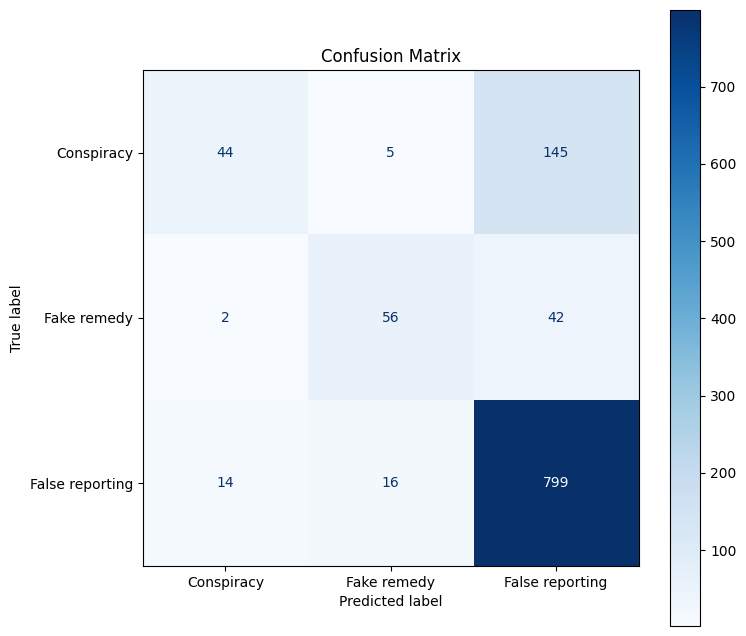

In [20]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)

# Adjust the plot size and color map
fig, ax = plt.subplots(figsize=(8, 8))
disp.plot(cmap=plt.cm.Blues, ax=ax, values_format='d') # 'd' formats as integer
plt.title("Confusion Matrix")
plt.show()

In [21]:
# SAVING EVALUATION REPORT
save_evaluation_report(metrics, "../../../deep_models/unesco_results/textcnn_evaluation_report.json")

Evaluation report saved to ../../../deep_models/unesco_results/textcnn_evaluation_report.json


In [22]:
# SAVE MODEL AND TOKENIZER

# Save the Keras model
model.save('../../../shared/models/textcnn_unesco_model.keras')

# Save the Tokenizer
import pickle
with open('../../../shared/tokenizers/textcnn_unesco_tokenizer.pkl', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

print("\nModel and Tokenizer saved successfully.")


Model and Tokenizer saved successfully.
